In [1]:
import torch
import numpy as np

from torch.utils.data import DataLoader
import torch.utils.data as data_utils

from torch.optim import SGD, Adam

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

from datasets import get_dataset

from loss_fns import LogisticRegression, NLLSQ
from optimizers import SPS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from nn_models import SmallLeNet
from torch.functional import F

torch.random.manual_seed(0)
model = SmallLeNet().to(device)

w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print ("Total parameters",d)  

Total parameters 970


In [6]:
print(model._get_name())

SmallLeNet


In [3]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])
BS = 128
trainset = torchvision.datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=False)

testset = torchvision.datasets.MNIST(root='./datasets', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [4]:
for i, (images, labels) in enumerate(train_loader):  
        print(images.shape[2] * images.shape[3])
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        break

784


In [5]:
@torch.no_grad()
def eval_model(model, loss_fn, data_loader):
    n_correct = 0
    n_samples = 0
    loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss += loss_fn(outputs, labels).item() / len(data_loader)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()  
    
    acc = 100.0 * n_correct / n_samples

    return loss, acc

In [7]:
def train_nn(model, criterion, train_loader, test_loader, epochs, optimizer_class, **optimizer_kwargs):

    optimizer = optimizer_class(model.parameters(), **optimizer_kwargs)

    slack = 0

    hist = []
    with torch.no_grad():
        train_loss, train_acc = eval_model(model, criterion, train_loader) 
        # print(f"Epoch[{0}] Train Loss: {train_loss} | Train Acc: {train_acc}")

        test_loss, test_acc = eval_model(model, criterion, test_loader)
        # print(f"Epoch[{0}] Test Loss: {test_loss} | Test Acc: {test_acc}")

        hist.append([train_loss, train_acc, test_loss, test_acc])
        
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):  
            
            # images = images.reshape(-1, images.shape[2] * images.shape[3]).to(device)
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            def closure():
                outputs = model(images)
                return criterion(outputs, labels)
            
            loss = closure()

            if isinstance(optimizer, SPS):     
                optimizer.step(closure) 
                slack = optimizer.replay_buffer[-1]["slack"]
            else:
                loss.backward()
                optimizer.step()

        if epoch % 10 == 0:
            with torch.no_grad():
                train_loss, train_acc = eval_model(model, criterion, train_loader) 
                # print(f"Epoch[{epoch + 1}] Train Loss: {train_loss} | Train Acc: {train_acc}")

                test_loss, test_acc = eval_model(model, criterion, test_loader)
                # print(f"Epoch[{epoch + 1}] Test Loss: {test_loss} | Test Acc: {test_acc}")

                hist.append([train_loss, train_acc, test_loss, test_acc])
        
    return hist

In [8]:
EPOCHS = 200

In [8]:
torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_sgd = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    SGD,
    lr=0.01
)

Epoch[0] Train Loss: 2.3078583984741012 | Train Acc: 9.035
Epoch[0] Test Loss: 6.894175725378044 | Test Acc: 9.035
Epoch[1] Train Loss: 2.2928477248657506 | Train Acc: 17.926666666666666
Epoch[1] Test Loss: 6.84933492332507 | Test Acc: 17.926666666666666
Epoch[11] Train Loss: 0.2946014596200958 | Train Acc: 90.73833333333333
Epoch[11] Test Loss: 0.8800514940243618 | Test Acc: 90.73833333333333
Epoch[21] Train Loss: 0.20965927994565808 | Train Acc: 93.59833333333333
Epoch[21] Test Loss: 0.6263070209841631 | Test Acc: 93.59833333333333
Epoch[31] Train Loss: 0.17375324705222447 | Train Acc: 94.68833333333333
Epoch[31] Test Loss: 0.5190463239967726 | Test Acc: 94.68833333333333
Epoch[41] Train Loss: 0.1587449881826033 | Train Acc: 95.13
Epoch[41] Test Loss: 0.474212735398987 | Test Acc: 95.13
Epoch[51] Train Loss: 0.1501404329546604 | Train Acc: 95.45166666666667
Epoch[51] Test Loss: 0.4485086818836677 | Test Acc: 95.45166666666667
Epoch[61] Train Loss: 0.14451145280454386 | Train Acc: 95.

In [9]:
torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_adam = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    Adam,
    lr=0.01
)

Epoch[0] Train Loss: 2.3078583984741012 | Train Acc: 9.035
Epoch[0] Test Loss: 6.894175725378044 | Test Acc: 9.035
Epoch[1] Train Loss: 0.32940173366748415 | Train Acc: 89.79833333333333
Epoch[1] Test Loss: 0.9840090005735677 | Test Acc: 89.79833333333333
Epoch[11] Train Loss: 0.1877770225789501 | Train Acc: 94.25
Epoch[11] Test Loss: 0.560939003754953 | Test Acc: 94.25
Epoch[21] Train Loss: 0.1429410215709478 | Train Acc: 95.59833333333333
Epoch[21] Test Loss: 0.4270021599794554 | Test Acc: 95.59833333333333
Epoch[31] Train Loss: 0.1173679072703761 | Train Acc: 96.305
Epoch[31] Test Loss: 0.3506085892344355 | Test Acc: 96.305
Epoch[41] Train Loss: 0.10353184964900994 | Train Acc: 96.73833333333333
Epoch[41] Test Loss: 0.30927667188143737 | Test Acc: 96.73833333333333
Epoch[51] Train Loss: 0.09992843577717694 | Train Acc: 96.875
Epoch[51] Test Loss: 0.29851233362736324 | Test Acc: 96.875
Epoch[61] Train Loss: 0.09706540565504863 | Train Acc: 96.91166666666666
Epoch[61] Test Loss: 0.289

In [10]:
torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_sps_l1 = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    SPS,
    # lr=0.1,
    preconditioner="none",
    slack_method="L1"
)

Epoch[0] Train Loss: 2.3078583984741012 | Train Acc: 9.035
Epoch[0] Test Loss: 6.894175725378044 | Test Acc: 9.035


/home/farshed.abdukhakimov/projects/sps2/optimizers.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s - self.lmd + step_size_temp))
/home/farshed.abdukhakimov/projects/sps2/optimizers.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(0.0), torch.tensor(loss - s + self.lmd) ) / (1 + gnorm_square)


Epoch[1] Train Loss: 2.281753596974844 | Train Acc: 14.333333333333334
Epoch[1] Test Loss: 6.816193866122299 | Test Acc: 14.333333333333334
Epoch[11] Train Loss: 0.3085035636449166 | Train Acc: 90.40666666666667
Epoch[11] Test Loss: 0.9215807092322669 | Test Acc: 90.40666666666667
Epoch[21] Train Loss: 0.24059538118271181 | Train Acc: 92.365
Epoch[21] Test Loss: 0.7187212342337057 | Test Acc: 92.365
Epoch[31] Train Loss: 0.21185866225439356 | Train Acc: 93.32166666666667
Epoch[31] Test Loss: 0.6328771503013411 | Test Acc: 93.32166666666667
Epoch[41] Train Loss: 0.19529556572786783 | Train Acc: 93.845
Epoch[41] Test Loss: 0.5833988555819742 | Test Acc: 93.845
Epoch[51] Train Loss: 0.18393655625710104 | Train Acc: 94.30166666666666
Epoch[51] Test Loss: 0.5494665279272638 | Test Acc: 94.30166666666666
Epoch[61] Train Loss: 0.17587783514881436 | Train Acc: 94.53333333333333
Epoch[61] Test Loss: 0.5253930234700249 | Test Acc: 94.53333333333333
Epoch[71] Train Loss: 0.16810591114577708 | Tra

In [13]:
torch.random.manual_seed(42)

model = SmallLeNet().to(device)

small_lenet_sps_l1_d = train_nn(
    model, 
    F.nll_loss,
    train_loader,
    test_loader,
    EPOCHS,
    SPS,
    # lr=0.1,
    preconditioner="hutch",
    slack_method="L1"
)

Epoch[0] Train Loss: 2.3078583984741012 | Train Acc: 9.035
Epoch[0] Test Loss: 6.894175725378044 | Test Acc: 9.035
Epoch[1] Train Loss: 0.7494798077067836 | Train Acc: 76.795
Epoch[1] Test Loss: 2.23889190964638 | Test Acc: 76.795
Epoch[11] Train Loss: 0.23479248407775397 | Train Acc: 92.75333333333333
Epoch[11] Test Loss: 0.7013864651749471 | Test Acc: 92.75333333333333
Epoch[21] Train Loss: 0.20403332087689852 | Train Acc: 93.63
Epoch[21] Test Loss: 0.6095008120462778 | Test Acc: 93.63
Epoch[31] Train Loss: 0.20720277120595568 | Train Acc: 93.45333333333333
Epoch[31] Test Loss: 0.6189687878700197 | Test Acc: 93.45333333333333
Epoch[41] Train Loss: 0.1755117934379877 | Train Acc: 94.42333333333333
Epoch[41] Test Loss: 0.5242995612892754 | Test Acc: 94.42333333333333
Epoch[51] Train Loss: 0.17351296333981342 | Train Acc: 94.415
Epoch[51] Test Loss: 0.5183285337985511 | Test Acc: 94.415
Epoch[61] Train Loss: 0.2144152682457269 | Train Acc: 93.08166666666666
Epoch[61] Test Loss: 0.640514

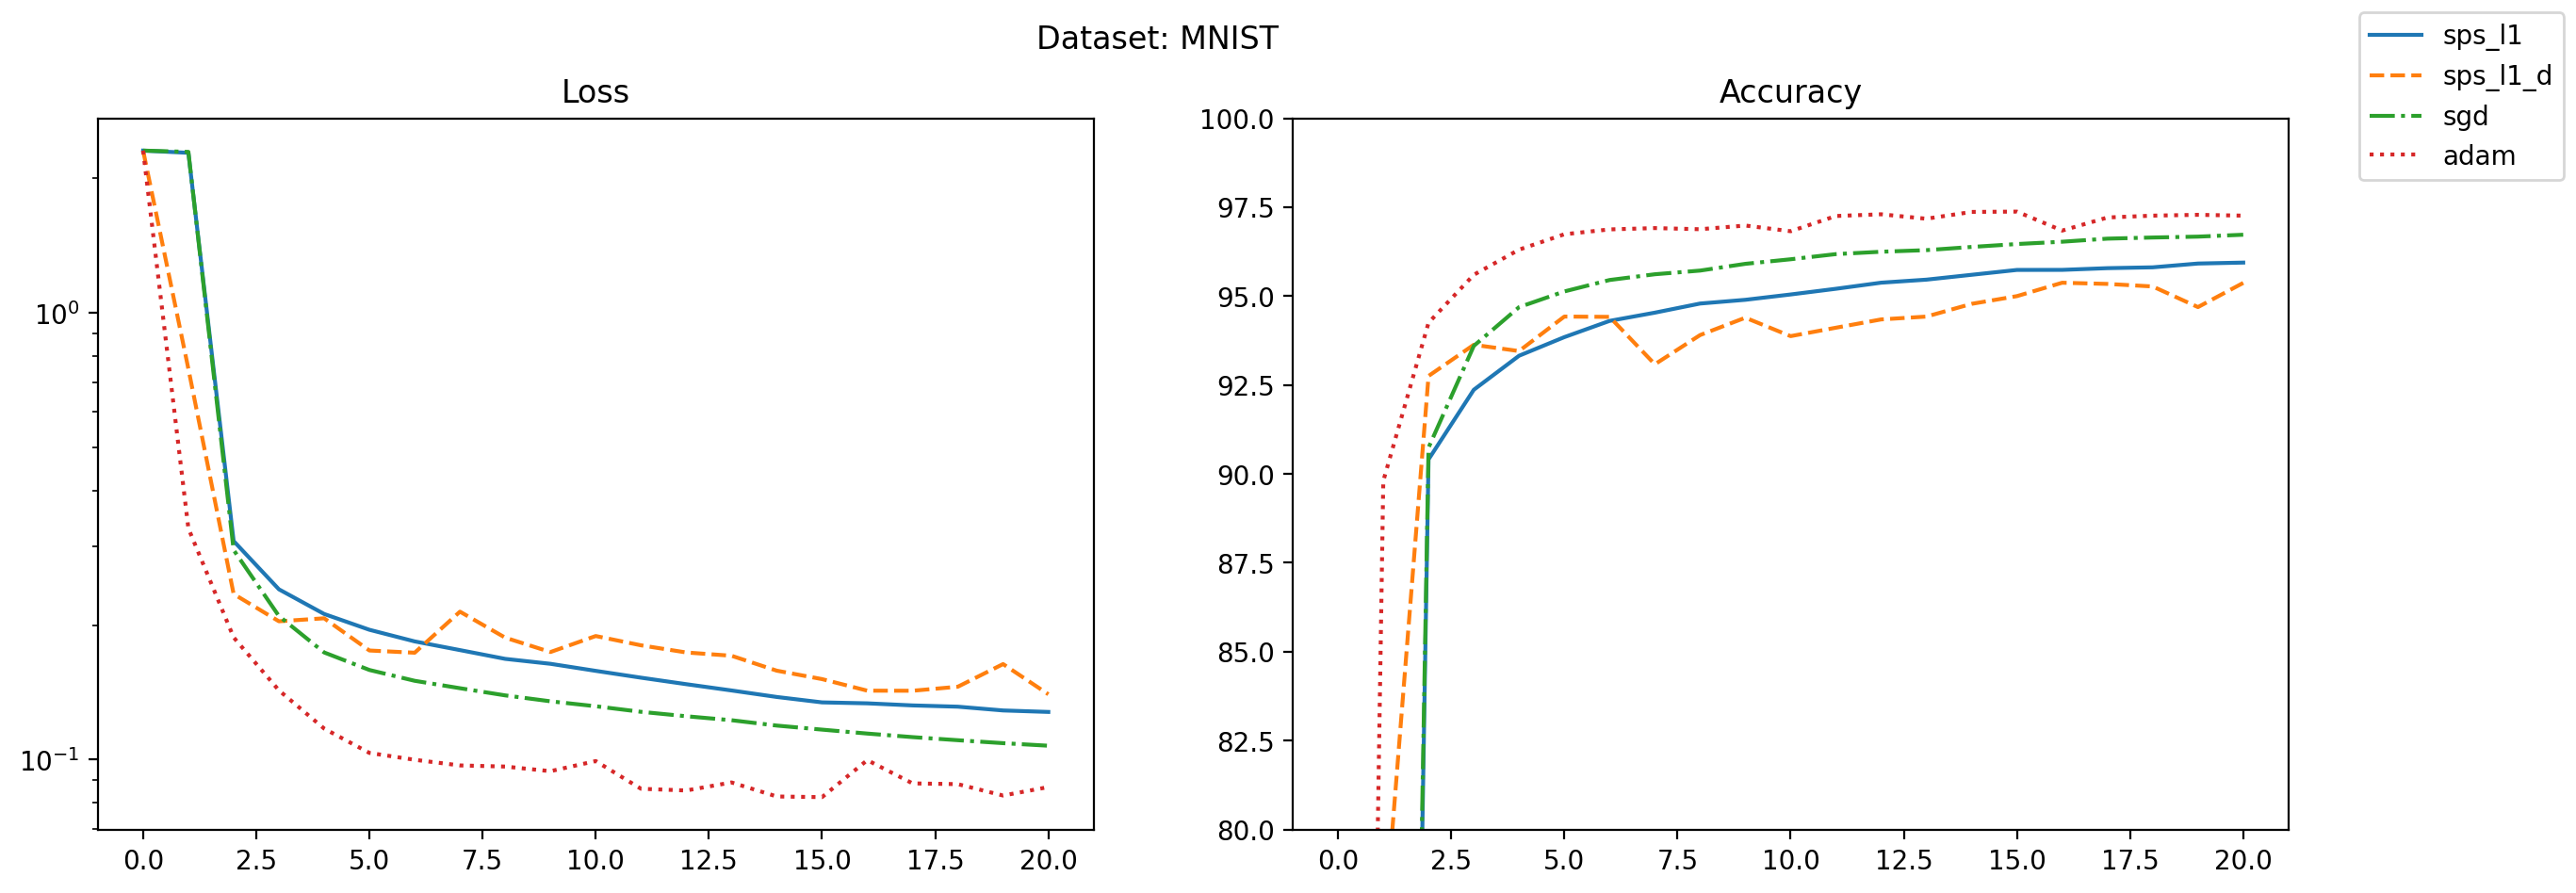

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

# hist.append([train_loss, train_acc, test_loss, test_acc])

ax[0].semilogy([x[0] for x in small_lenet_sps_l1])
ax[0].semilogy([x[0] for x in small_lenet_sps_l1_d], "--")
ax[0].semilogy([x[0] for x in small_lenet_sgd], "-.")
ax[0].semilogy([x[0] for x in small_lenet_adam], ":")
ax[0].set_title("Loss")


ax[1].set_ylim(80, 100)
ax[1].plot([x[1] for x in small_lenet_sps_l1])
ax[1].plot([x[1] for x in small_lenet_sps_l1_d], "--")
ax[1].plot([x[1] for x in small_lenet_sgd], "-.")
ax[1].plot([x[1] for x in small_lenet_adam], ":")
ax[1].set_title("Accuracy")

fig.suptitle(f"Dataset: Training MNIST")
fig.legend(["sps_l1", "sps_l1_d", "sgd", "adam"])

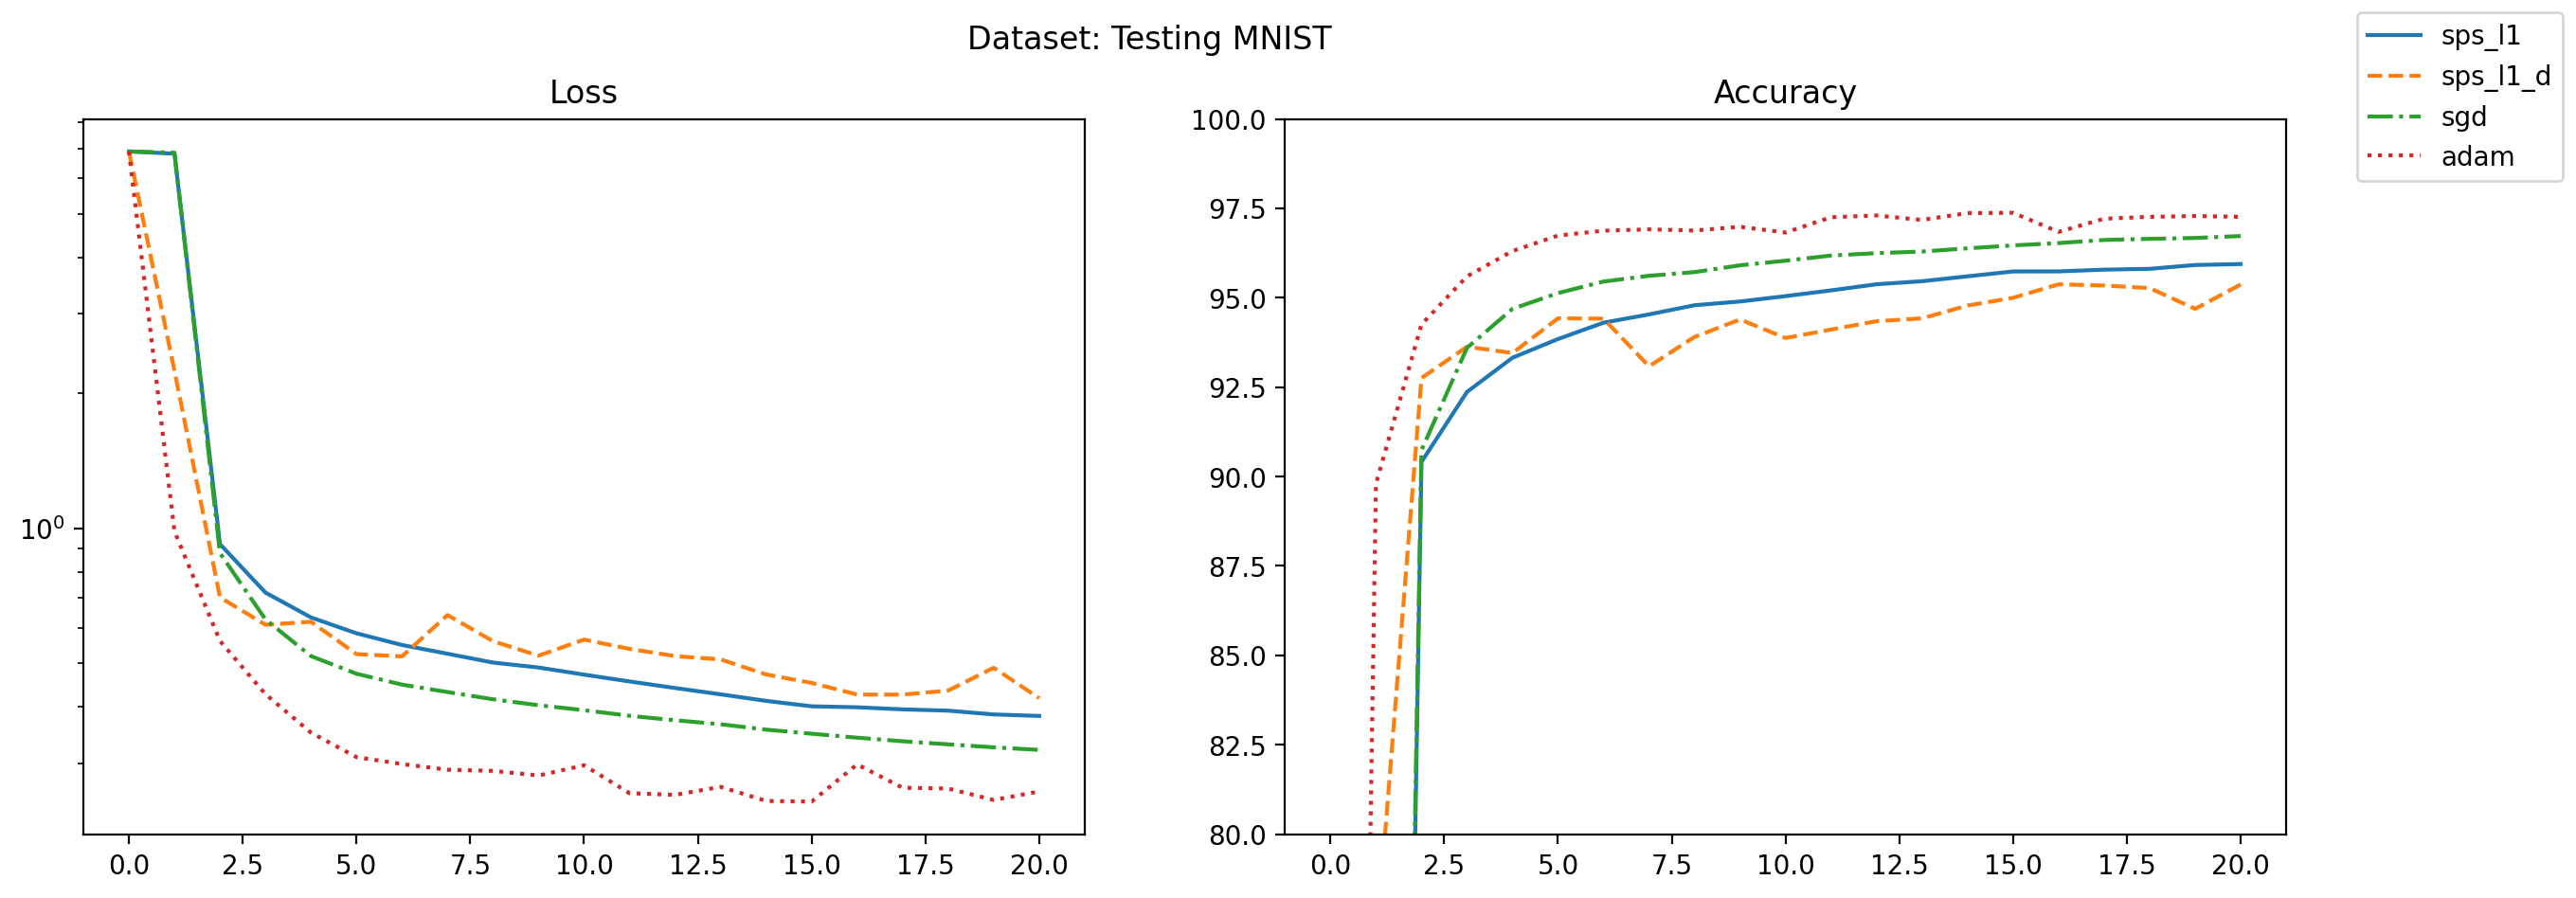

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

# hist.append([train_loss, train_acc, test_loss, test_acc])

ax[0].semilogy([x[2] for x in small_lenet_sps_l1])
ax[0].semilogy([x[2] for x in small_lenet_sps_l1_d], "--")
ax[0].semilogy([x[2] for x in small_lenet_sgd], "-.")
ax[0].semilogy([x[2] for x in small_lenet_adam], ":")
ax[0].set_title("Loss")


ax[1].set_ylim(80, 100)
ax[1].plot([x[3] for x in small_lenet_sps_l1])
ax[1].plot([x[3] for x in small_lenet_sps_l1_d], "--")
ax[1].plot([x[3] for x in small_lenet_sgd], "-.")
ax[1].plot([x[3] for x in small_lenet_adam], ":")
ax[1].set_title("Accuracy")

fig.suptitle(f"Dataset: Testing MNIST")
fig.legend(["sps_l1", "sps_l1_d", "sgd", "adam"])

In [ ]:
import os

os.makedirs("results/MNIST/SmallLeNet//SGD/lr_0.1/seed_0/")